In [32]:
# Example: Robust spin test demo with error reporting and diagnostic checks
# This needs to use the conda environment with enigmatoolbox installed (lami)
# It appears that the enigma toolbox depends on multiple dependencies and therefore just installing enigmatoolbox
# does not work. So use this code to perform the spin test
import os
import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from enigmatoolbox.permutation_testing import spin_test, shuf_test


In [ ]:
# --- Parameters block: set all user-controlled parameters here ---

hcp_save_subpath = 'HCP'
exvivo_save_subpath = 'EXVIVO'
hemi = 'rh'# lh or rh
hcp_grad_file_lh = f'{hcp_save_subpath}/hcp_template_grad_{hemi}.npy'
npz_path = f'{exvivo_save_subpath}/grad_algnd2_total_grad_{hemi}.npz'

#metric_labels = ['Total', 'Supra', 'Infra','Supra/Total','Infra/Total']  # Can be any length
bar_width = 0.12
colormap_name = 'tab20'
ylim_min = -0.5
ylim_max = 0.5
font_size = 16
ncomp = 3 #number of components to plot ; if not specified, all will be plotted

#for spin test
number_of_rotations = 1000
# ---------------------------------------------------------------

# Load HCP gradient maps and calculate spatial similarity
if os.path.exists(hcp_grad_file_lh):
    #load hcp data 
    hcp_tmpl_lh = np.load(hcp_grad_file_lh)#this is 32k flsr space
    
    with np.load(npz_path, allow_pickle=True) as data:
        arrays = data['arrays']
        labels = data['labels']
        exvivo_grad_names = data['metrics']
        exvivo_grads_lh = list(zip(arrays, labels, exvivo_grad_names))

    print(exvivo_grad_names)

    #this should be in the exact order of the exvivo_grad_names
    # this is 32k flsr space
    exvivo_grad_arrays = [
        exvivo_grads_lh[0][0], #total
        exvivo_grads_lh[1][0], #supra
        exvivo_grads_lh[2][0], #infra
        exvivo_grads_lh[3][0], #supra/total
        exvivo_grads_lh[4][0], # Note: "Infra/Total" index must match data
        exvivo_grads_lh[5][0], # Note: "Supra/Total" index must match data
    ]
    

    grad_dict = dict(zip(exvivo_grad_names, exvivo_grad_arrays))

    # --- Compute spatial correlations between ex vivo and HCP gradients --- 
    calc_corrs = []
    for grad_name, grad_arr in grad_dict.items():
        # Calculate the spatial correlation (Pearson) between components for ex vivo and HCP
        n_comp = grad_arr.shape[1]
        n_comp_hcp = hcp_tmpl_lh.shape[1]
        min_n = min(n_comp, n_comp_hcp)
        # Trim to the minimum number of components present in both sets
        corrs = np.diag(np.corrcoef(grad_arr[:, :min_n].T, hcp_tmpl_lh[:, :min_n].T)[:min_n, min_n:])
        calc_corrs.append((grad_name, corrs))
    
    # --- Compute spin test p-values for each set of correlations ---
    spin_results = []
    for grad_name, grad_arr in grad_dict.items():
        n_comp = grad_arr.shape[1]
        n_comp_hcp = hcp_tmpl_lh.shape[1]
        min_n = min(n_comp, n_comp_hcp)
        p_spin_vec = []
        null_dists = []
        for i in range(min_n):
            # spin_test expects 1D input vectors (corresponding surface vertex maps)
            p_spin, null_dist = spin_test(
                grad_arr[:, i], 
                hcp_tmpl_lh[:, i], 
                n_rot=number_of_rotations, 
                surface_name='fsa5',
                parcellation_name='schaefer_400',
                type='pearson', 
                null_dist=True
            )

            p_spin_vec.append(p_spin)
            null_dists.append(null_dist)
        spin_results.append({
            'grad_name': grad_name,
            'p_spin': np.array(p_spin_vec),
            'null_dist': null_dists
        })


    

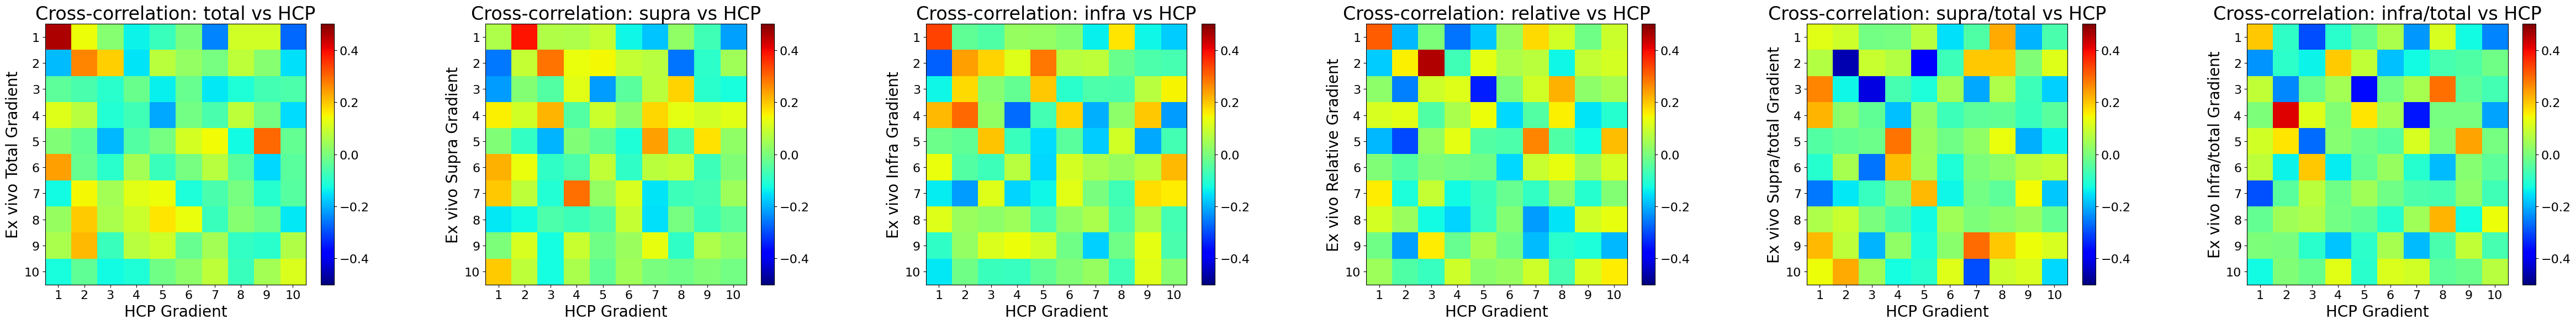

In [22]:
# Plot all cross-correlation matrices in a single figure, in a single row
num_grads = len(grad_dict)
fig, axes = plt.subplots(1, num_grads, figsize=(8*num_grads, 6), squeeze=False)

# Set font size parameters
title_fontsize = 24
label_fontsize = 20
tick_fontsize = 16
cbar_label_fontsize = 18
colormap = 'jet'
for idx, (grad_name, grad_arr) in enumerate(grad_dict.items()):
    n_comp = grad_arr.shape[1]
    n_comp_hcp = hcp_tmpl_lh.shape[1]
    min_n = min(n_comp, n_comp_hcp)
    # Compute full cross-correlation matrix between ex vivo and HCP gradients
    corrs = np.corrcoef(grad_arr[:, :min_n].T, hcp_tmpl_lh[:, :min_n].T)[:min_n, min_n:]
    ax = axes[0, idx]
    im = ax.imshow(corrs, cmap=colormap, vmin=-0.5, vmax=0.5)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # Increase colorbar tick labels and, if needed, label font size
    cbar.ax.tick_params(labelsize=tick_fontsize)
    # Optionally, set cbar label font size if you add a label
    # cbar.set_label('Correlation', fontsize=cbar_label_fontsize)
    ax.set_title(f'Cross-correlation: {grad_name} vs HCP', fontsize=title_fontsize)
    ax.set_xlabel('HCP Gradient', fontsize=label_fontsize)
    ax.set_ylabel(f'Ex vivo {grad_name.capitalize()} Gradient', fontsize=label_fontsize)
    ax.set_xticks(range(min_n), [f'{i+1}' for i in range(min_n)], fontsize=tick_fontsize)
    ax.set_yticks(range(min_n), [f'{i+1}' for i in range(min_n)], fontsize=tick_fontsize)
    # Increase tick parameters directly (in case some backends ignore fontsize in set_xticks)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.tight_layout()
plt.show()

In [23]:
# Truncate to min(len(calc_corrs), len(metric_labels)) in case metric_labels or corrs is changed
max_len = min(len(exvivo_grad_names), len(calc_corrs))
corr_diags = [(exvivo_grad_names[i], calc_corrs[i][1]) for i in range(max_len)]
ncomp = 3
ALPHA = 0.05
# Gather spin p-values per gradient for annotation
spin_pvals_dict = {}
for res in spin_results:
    spin_pvals_dict[res['grad_name']] = res['p_spin']

if len(corr_diags) == 0:
    print("No correlation vectors specified, nothing to plot.")
else:
    # Determine the number of components actually present; use the minimum length of any values vector
    if ncomp is not None:
        num_components = ncomp
    else:
        num_components = min(len(values) for _, values in corr_diags)
    x = np.arange(num_components)

    fig_height = max(4, 1.5 * max_len)
    fig, ax = plt.subplots(figsize=(num_components*3, fig_height))

    n_groups = len(corr_diags)
    offsets = (np.arange(n_groups) - (n_groups - 1) / 2) * bar_width

    cmap = cm.get_cmap(colormap_name)
    if n_groups > cmap.N:
        colors = [cmap(i / n_groups) for i in range(n_groups)]
    else:
        colors = cmap(np.linspace(0, 1, n_groups))

    # Calculate minimum p-value threshold based on number_of_rotations
    pval_min = 1.0 / number_of_rotations

    for idx, ((label, values), color) in enumerate(zip(corr_diags, colors)):
        bar_container = ax.bar(x + offsets[idx], values[:num_components], bar_width, label=label, color=color)

        # Get matching spin p-values for the label/gradient
        pvals = spin_pvals_dict.get(label, None)
        if pvals is not None:
            for comp_idx, rect in enumerate(bar_container):
                pval = pvals[comp_idx]
                if pval < ALPHA:  # Significant bar, annotate with p-value
                    height = rect.get_height()
                    # Determine position above or below the bar depending on sign
                    if height >= 0:
                        v_offset = 0.01
                        v_align = 'bottom'
                        y_text = height + v_offset
                    else:
                        v_offset = -0.01
                        v_align = 'top'
                        y_text = height + v_offset
                    
                    # Annotate p-value: special display if below 1/number_of_rotations
                    if pval < pval_min:
                        pval_str = f"< {1.0/number_of_rotations:.2g}"
                    else:
                        pval_str = f"{pval:.2g}"
                    ax.text(
                        rect.get_x() + rect.get_width() / 2., y_text,
                        pval_str,
                        ha='center', va=v_align,
                        fontsize=font_size - 2,
                        color='black', fontweight='bold'
                    )

    ax.set_xlabel('Components', fontsize=font_size)
    ax.set_ylabel('Spatial similarity ($\\rho$)', fontsize=font_size)
    ax.set_xticks(x)
    ax.set_xticklabels([f'{i+1}' for i in x], fontsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size, left=False)
    # Put the legend outside the plot to the right
    ax.legend(fontsize=font_size, loc='center left', bbox_to_anchor=(1.15, 0.5), ncol=1, frameon=False)
    ax.set_title('Spatial similarity between \nex vivo and HCP (total) gradient maps', fontsize=font_size)
    ax.set_ylim(ylim_min, ylim_max)
    
    # Add an extra note about the spin test p-values, with "spin" as subscript
    # This can be a figure-level text placed below the plot
    fig.text(
        0.5, -0.03,
        rf"* $p_{{\mathrm{{spin}}}}$ values: actual spin test p-values (${number_of_rotations}$ rotations)",
        ha='center', va='top', fontsize=font_size-1
    )

    # Remove all spines (box around plot)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis='y', which='both', left=True, right=False)

    plt.tight_layout()
    plt.show()


NameError: name 'spin_results' is not defined

In [10]:
#save spin_pvals_dict to the subpath of exvivo_save_subpath
with open(f'{exvivo_save_subpath}/spin_pvals_dict.pkl', 'wb') as f:
    pickle.dump(spin_pvals_dict, f)

In [3]:
import nibabel as nib
#load 
file_name =  '/Users/dennis.jungchildmind.org/Desktop/subcortical_test/mri/aparc+aseg.upsampled.mgz'
dat = nib.load(file_name)

#get the aseg labels


In [4]:
#downsample dat by 2
dat2 = dat.get_fdata()[::4, ::4, ::4]


In [ ]:
print(np.unique(dat2))
#cat $FREESURFER_HOME/FreeSurferColorLUT.txt | grep -i thal
#10 is left thalamus, 49 is right thalamus

[   0.    2.    4.    7.    8.   10.   11.   12.   13.   16.   17.   18.
   26.   28.   77. 1001. 1002. 1003. 1005. 1006. 1007. 1008. 1009. 1010.
 1011. 1012. 1013. 1014. 1015. 1016. 1017. 1018. 1019. 1020. 1021. 1022.
 1023. 1024. 1025. 1026. 1027. 1028. 1029. 1030. 1031. 1032. 1033. 1034.
 1035.]


(160, 350, 400)


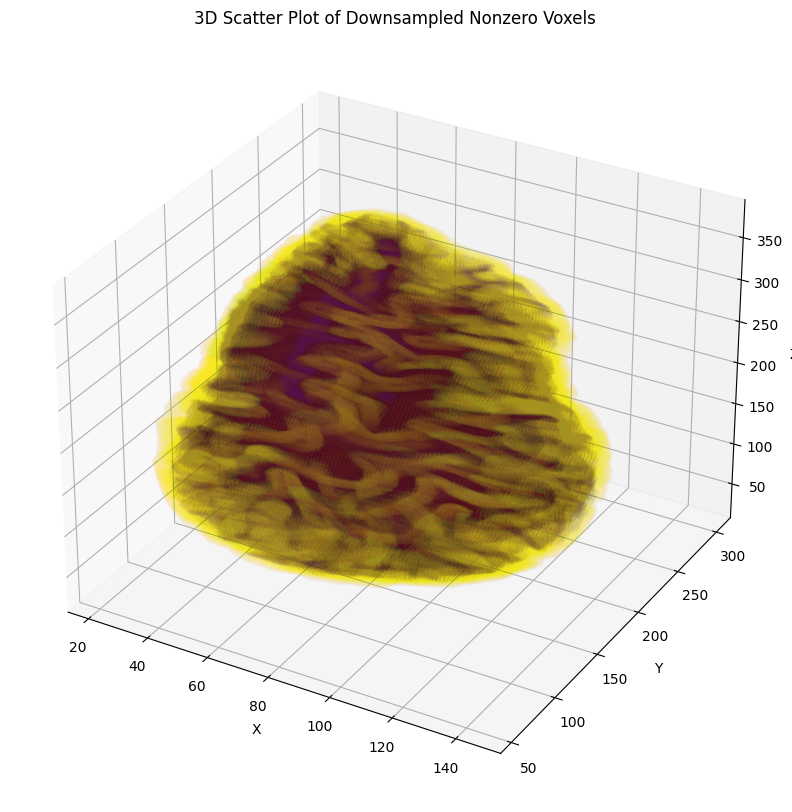

In [11]:
print(dat2.shape)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# dat2 is the downsampled volumetric data
# Get the indices of nonzero voxels for visualization
coords = np.column_stack(np.where(dat2 > 0))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#color the voxels by the value
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=dat2[coords[:, 0], coords[:, 1], coords[:, 2]], s=1, alpha=0.01)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of Downsampled Nonzero Voxels')
plt.show()


(193, 229, 193)


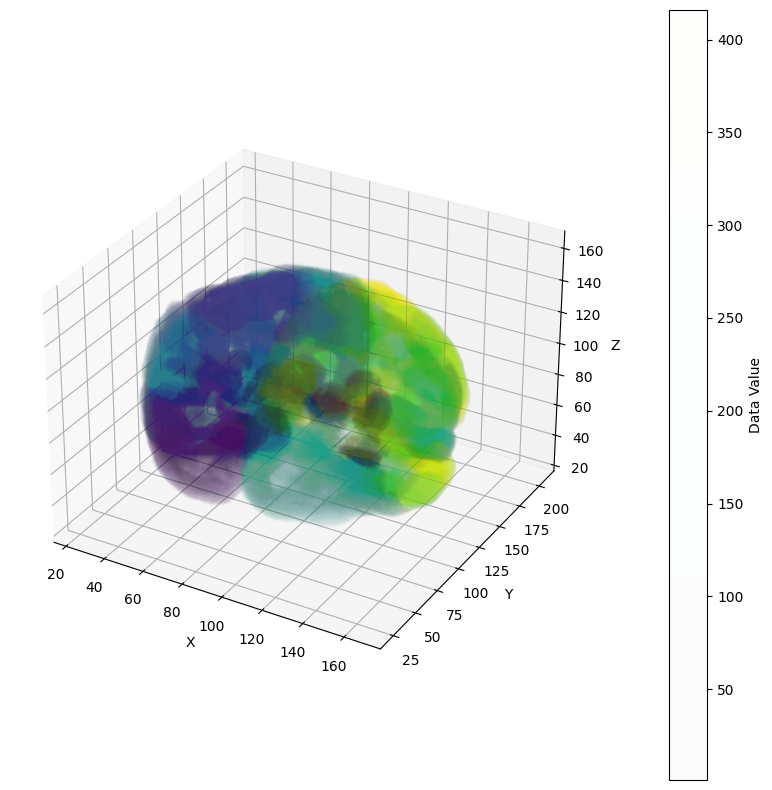

In [25]:

mni_volumetric = '/Users/dennis.jungchildmind.org/Desktop/subcortical_test/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_1mm.nii.gz'
c = nib.load(mni_volumetric)
print(c.get_fdata().shape)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Get the data
data = c.get_fdata()

# Find nonzero voxels for visualization
coords = np.column_stack(np.where(data > 0))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# Color all points according to their data value (colormap normalized automatically).
values = data[coords[:, 0], coords[:, 1], coords[:, 2]]
scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=values, s=1, alpha=0.01, cmap='viridis')
plt.colorbar(scatter, ax=ax, pad=0.1, label='Data Value')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


    

In [31]:
print(c.get_header())

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b'          '
db_name         : b'                  '
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 193 229 193   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10                                                                          '
aux_file        : b'                        '
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quate

/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_99361/4000315244.py:1: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  print(c.get_header())
